# **Audio Recognition**
Autori: Confalonieri Riccardo | Mariani Ginevra | Mora Lorenzo <br>
E-mail: r.confalonieri5@campus.unimib.it | g.mariani34@campus.unimib.it | l.mora4@campus.unimib.it <br>

In questo notebook viene affrontato il problema di riconoscimento della voce di uno di tre interlocutori. A tale scopo verranno sperimentati diversi *feature extractors* e diversi approcci di classificazione, sia di Machine Learning che Deep Learning.

In [3]:
%%capture
!pip3 install sounddevice

In [4]:
%%capture
!sudo apt-get install libportaudio2

In [1]:
# Definizione parametri e costanti
DRIVE_PATH = '/content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/'
AUDIO_PATH = '/content/audio_nuovi/'
MODEL_PATH = '/content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Model/Processing-1D/'

In [5]:
from google.colab import drive
import tarfile
import os
import numpy as np
import librosa
import librosa.display
from librosa.display import specshow
import IPython.display as ipd
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
from shutil import copyfile
import pickle
import soundfile as sf
import shutil
import cv2
import seaborn as sns
import sklearn

# Classification tools
import sounddevice as sd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Activation, Dropout, Conv2D
from keras.layers import MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical, get_source_inputs
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.utils.vis_utils import plot_model

In [6]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Riproduzione e visualizzazione audio
Di seguito riportiamo un esempio di un audio originale di lunghezza 5sec in cui Ginevra legge un libro.

In [ ]:
audio_test = DRIVE_PATH + 'Data/audio/audio_test.wav'
ipd.Audio(audio_test)

Text(0, 0.5, 'Amplitude')

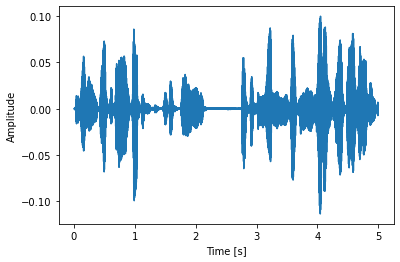

In [ ]:
sig, rate = librosa.load(audio_test, sr=44100)
n = sig.shape[0]
f, ax = plt.subplots()
ax.plot(np.arange(n) / rate, sig)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')

Visualizziamo lo spettrogramma del file che verrà utilizzato per l'ultimo approccio neurale in cui verrà descritto più approfonditamente.

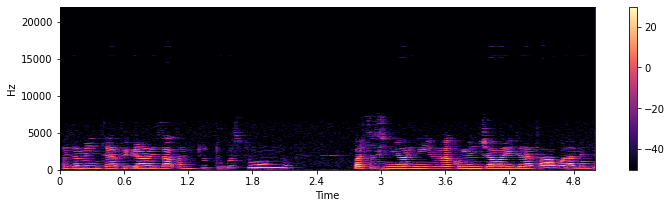

In [ ]:
# Spettrogramma dell'audio
sig_stft = librosa.stft(sig)
sig_db = librosa.amplitude_to_db(abs(sig_stft))
plt.figure(figsize=(12, 3))
librosa.display.specshow(sig_db, sr=rate, x_axis='time', y_axis='hz')
plt.colorbar()

## Audio preprocessing

In questa sezione vengono definiti, ed eseguiti, alcuni metodi per tagliare opportunamente gli audio. In particolare ogni audio di 5sec viene tagliato ogni 2sec considerando l'overlapp tra i diversi crop. In questo modo si ottengono, per ogni singolo audio, quattro nuovi audio croppati. <br>
Oltre al cropping, se richiesto, vengono effettuate anche delle manipolazioni ai file audio per aumentare i dati a disposizione. Nello specifico sono considerate per la data augmentation le seguenti casistiche:
* *pitch shifting* $⇒$ modifica il pitch originale dell’audio aumentandolo o diminuendolo,
* *time stretching* [$\times 1.5$] $⇒$ aumenta la velocità del segmento,
* *time stretching* [$\times 0.5$] $⇒$ diminuisce la velocità del segmento.


**NOTA:** Tutte queste funzioni sono già state eseguite salvando il risultato in appositi file zippati. Non è quindi necessario eseguirle nuovamente!

In [ ]:
# sposto il file da google drive alla root della macchina, questo perchè altrimenti
# l'estrazione è lunga!
copyfile('/content/drive/MyDrive/DSIM_progetto/Data/audio_nuovi.tar', 'audio_nuovi.tar')

# estraggo il file
tar = tarfile.open('audio_nuovi.tar')
tar.extractall()
tar.close()

In [ ]:
# funzione che controlla che la lunghezza in input sia corretta. Altrimenti
# se eccede viene semplicemente croppata, se invece la dimensione è minore
# di quella richiesta vengono inseriti tanti zeri quanti necessari per matchare
# la lunghezza richiesta
def check_length(input, size):
    # Elimina eventuali valori oltre il numero consentito
    output = input[0:min(size, input.shape[0])]
    # Aggiungi valori nulli per raggiungere la dimensione richiesta
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output


# funzione che, dato un audio in input, restituisce in audio una lista di audio
# croppati ogni tot. secondi (new_length). Attraverso il parametro overlap è possibile
# specificare se l'overlapping dei crop sia da considerasi oppure no
def make_crop(audio, new_length = 2, rate = 44100, overlap = True):
    # all'inizio taglio dal primo valore
    start_crop = 0
    # calcolo in primo punto di taglio dell'audio
    end_point = rate*new_length

    lst_crops = []
    # itero su tutta la lunghezza dell'audio
    while end_point <= len(audio):
    lst_crops.append(audio[start_crop:end_point])
    # se multi è definito creo crop sovrapposti di un secondo
    if overlap:
        start_crop = start_crop + rate
        end_point = end_point + rate
    # altrimenti non creo sovrapposizioni e inizio il nuovo crop dove 
    # è terminato il precedente
    else:
        start_crop = end_point
        end_point = end_point + rate*new_length

    return lst_crops

# funzione che effettua la data augmentation dell'audio in input
# Restituisce tre audio: pitch modificato, audio fast, audio slow
def make_augmentation(audio, rate = 44100):
    # cambio del pitch dell'audio
    pitched_data = librosa.effects.pitch_shift(audio, rate, -.8)
    # velocizzazione dell'audio
    fast_data = librosa.effects.time_stretch(audio, 1.5)
    # rallentamento dell'audio
    slow_data = librosa.effects.time_stretch(audio, 0.5)

    return pitched_data, check_length(fast_data, 2*rate), check_length(slow_data, 2*rate)

In [ ]:
# funzione che itera su una cartella contenente degli audio e li taglia 
# ogni tot secondi salvando il risultato in nella cartella di destinazione
# specificata. 
# overlap: indica se i crop degli audio siano sovrapposti o meno
# augmentation: indica se effettuare la data augmentetion sugli audio
def process_audio(path, dest_path, overlap = True, augmentation = True):
  # itero su tutti gli audio della cartella
  for f in sorted(os.listdir(path)):
    # se è un audio lo elaboro per cropparlo
    if f.endswith('.wav'):
      # carico il file
      rate, signal = wav.read(path + f)
      # creo i crop dell'audio
      crops = make_crop(signal, 2, rate, True) 

      # Contatore per aggiornare il nome del file
      count = 0
      # scrivo i nuovi file
      for c in crops:
        # definisco il nome del file per evitare nomi doppi
        filename = dest_path + f[:-4] + '_crop' + str(count) + '.wav'
        # scrivo il file
        wav.write(filename, rate = rate, data = c)

        # se è richiesto applico l'augmentation e scrivo anche questi file
        if augmentation:
          # applico l'augmentation
          audio_pitch, audio_fast, audio_slow = make_augmentation(c, rate)

          #scrivo i file ottenuti
          filename = dest_path + f[:-4] + '_pitch' + str(count) + '.wav'
          wav.write(filename, rate = rate, data = audio_pitch)
          filename = dest_path + f[:-4] + '_fast' + str(count) + '.wav'
          wav.write(filename, rate = 44100, data = audio_fast)
          filename = dest_path + f[:-4] + '_slow' + str(count) + '.wav'
          wav.write(filename, rate = 44100, data = audio_slow)

        count = count + 1

In [ ]:
# estraggo i crop, e per ogni crop applico anche la data augmentation
process_audio('./audio_nuovi/', '/content/drive/MyDrive/DSIM_progetto/Data/audio_crop_aug/', True, True)

# estraggo solo i crop
# process_audio('./audio_nuovi/', '/content/drive/MyDrive/DSIM_progetto/Data/audio_cropped/', True, True)

## Feature extractors
Si è deciso di testare diversi tipi di estrattori e di combinarli tra di loro al fine trovare la combinazione migliore per il task e i nostri dati. Di seguito presentiamo gli approcci sperimentati:
- Deviazione standard;
- Zero Crossing Rate;
- RMSE;
- Spectral Centroids;
- MFCC.
 

Di seguito sono raccolte una serie di funzioni per estrarre da una traccia audio le **features** descritte precedentemente.

Da ultimo abbiamo implementato tre funzioni `combo` che combinano i diversi feature extractor.

In [ ]:
def identity(input):
  return input

def sdev(input):
  return np.std(input, keepdims = True)

def zcr(input):
  zcr = librosa.feature.zero_crossing_rate(input).mean()
  zcr = np.array([zcr])
  return zcr

def rmse(input):
  rmse = librosa.feature.rms((input*1.0), frame_length=1024, hop_length=512,
                              center=True)
  return rmse[0]

def spectral_centroids(input):
  return librosa.feature.spectral_centroid(input, sr = 44100)[0]

def mfcc(input, rate = 44100):
  return librosa.feature.mfcc(input, sr = rate, n_mfcc = 13)

def combo1(input):
  mfcc_spec = mfcc(input).flatten()
  return np.concatenate((sdev(input), rmse(input), mfcc_spec))

def combo2(input):
  return np.concatenate((sdev(input), zcr(input), spectral_centroids(input)))

def combo3(input):
  mfcc_spec = mfcc(input).flatten()
  return np.concatenate((spectral_centroids(input), mfcc_spec))

Di seguito si mostra l'applicazione dei feature extractors ad uno degli audio *croppati*.

In [ ]:
rate, sig = wav.read('/content/audio_cropped/Ginevra_1_02-07-2022_150611_crop0.wav')

### **Zero Crossing Rate**
ZCR è una misura ponderata del numero di volte il che il segnale cambia segno in un frame.

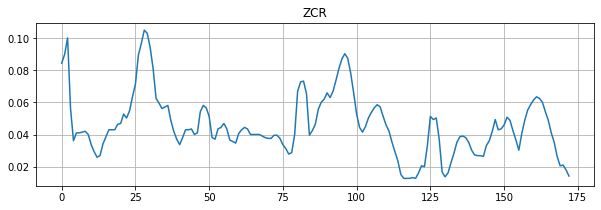

In [ ]:
zcrs = librosa.feature.zero_crossing_rate(sig)
plt.figure(figsize=(10, 3))
plt.plot(zcrs[0])
plt.title('ZCR')
plt.grid()

### **RMSE**
La root-mean-square energy (RMSE) in un segnale è definita come: 
$\sqrt{\frac{1}{N}\sum_{n} |x(n)|^2}$

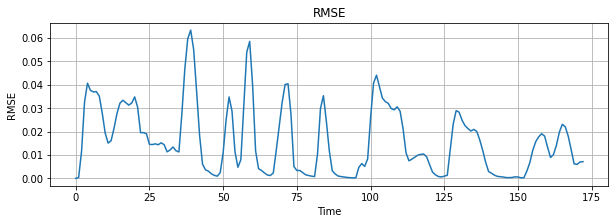

In [ ]:
rmse_ = rmse(sig)
plt.figure(figsize=(10,3))
plt.plot(rmse_)
plt.ylabel('RMSE')
plt.xlabel('Time')
plt.title('RMSE')
plt.grid()

### **Spectral Centroids**
Il *baricentro spettrale* è una misura utilizzata nell'elaborazione dei segnali digitali per caratterizzare uno spettro. Indica dove si trova il centro di massa dello spettro.

(0.0, 173.0)

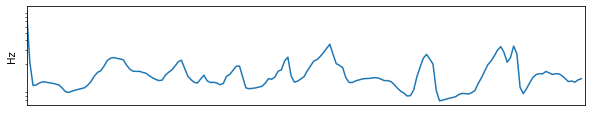

In [ ]:
cent = spectral_centroids(sig)
plt.figure(figsize=(10,4))
plt.subplot(2, 1, 1)
plt.grid()
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.yticks([])
plt.xlim([0, cent.shape[-1]])

### **Mel Frequency Cepstral Coefficients**
I coefficienti MFCC sono coefficienti che costituiscono collettivamente un MFC e derivano da un tipo di rappresentazione cepstrale del segnale audio.

Text(0.5, 1.0, 'MFCC')

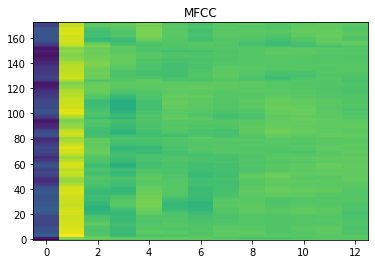

In [ ]:
mfcc_ = mfcc(sig, rate)
# plt.figure(figsize=(10,3))
# plt.plot(mfcc_)
# plt.ylabel('MFCC')
# plt.xlabel('Time')
# plt.title('MFCC')
# plt.grid()
ig, ax = plt.subplots()
mfcc_data= np.swapaxes(mfcc_, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', origin='lower', aspect='auto')
ax.set_title('MFCC')

## Data Loader
Per velocizzare il caricamento gli audio necessari sono già state preventivamente <i>salvate in formato .tar</i>. 
Avendo creato manualmente gli audio si è certi che le classi siano bilanciate, questo supponendo che nel caso reale tutti e $3$ i componenti sottopongano la stessa quantità di audio al modello per l'inferenza altrimenti avrebbe più senso creare un test set sbilanciato a favore della persona che effettua più inferenze per verificare la bontà del modello. <br>
Una volta importati localmente gli audio, essendo salvati in un'unica cartella senza suddivisione, è necessario suddividerli per creare i subset di training, e test necessari per i diversi modelli. Durante la fase di caricamento viene anche inferita in maniera automatica a partire dal nome del file.


In [ ]:
def load_zip(file_path, filename, delete_zip = True):
  """
  Funzione che copia in locale i file .tar e li estrai. Il file originale, se
  richiesto, viene eliminato.
  
  :param str file_path: Percorso per il file .tar
  :param str filename: Nome del tar
  :param boolean delete_zip: Indica se eliminare il file .zip scaricato. Default True
  """

  # Scarico sulla macchina locale lo zip
  copyfile(file_path, filename)
  # estraggo il tar
  tar = tarfile.open(filename)
  tar.extractall()
  tar.close()
  # se richiesto cancello lo zip dalla root
  if delete_zip:
    os.remove(filename)

def load_data(path, feature_extractor, type_class=None, normalize=False):
  """
  Funzione data loader.

  :param feature_extractor: tipo di estrattore per le features audio
  :param str typle_class: tipo di classificatore ('ml')
  :param normalize = True per applicare normalizzazione dei dati

  :return restituisce in output i dati e le label suddivisi in train e test
  """
  # salvo le label (classi) di riferimento per tutti i file
  labels = []
  # features estratte per tutti i file
  features = []
  
  # itero su tutti i file presenti nella cartella
  for f in sorted(os.listdir(path)):
    # considero solamente i file audio
    if f.endswith('.wav'):
      # carico il file audio
      _, signal = wav.read(path + f)

      # se la funzione è di machine learning e la features richiesta è mfcc()
      # è necessario aggiungere un flatten per evitare errori
      if type_class == 'ml' and feature_extractor == mfcc:
        cur_features = feature_extractor(signal).flatten()
      # altrimenti è possibile utilizzare le features cosi come definite nelle
      # rispettive funzioni
      else:
        cur_features = feature_extractor(signal)

      # Aggiungo le features appena create alla lsita
      features.append(cur_features)

      # Estraggo la classe dal nome del file (è la prima parola prima dell underscore)
      label = f.split('_')[0]
      # aggiungo la label alla lista
      labels.append(label)

  # splittimo i dati in training e test (90% training, 10 test)
  X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                      test_size=0.1,
                                                      random_state=1,
                                                      stratify = labels)
  

  # se richiesto viene fatta una normalizzazione dei dati standardizzando i valori
  # come (val-media)/std_deviation sia per il training che per il test
  if normalize:
    eps = 0.001
    X_train = np.array(X_train)
    X_train_mean = X_train.mean(axis=0)
    X_train_std = X_train.std(axis=0)
    X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
    X_train = [row for row in X_train]

    X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/
              (X_train_std + eps)]

  # restituisco gli split estratti
  return X_train, X_test, y_train, y_test

Scarichiamo quindi i due zip, quello con gli audio di lunghezza a due secondi e lo zip con anche gli audio aumentati (cambio di pitch e velocità).

In [ ]:
# carico lo zip base
load_zip(DRIVE_PATH + 'Data/audio/audio_cropped.tar', 'audio_cropped.tar')
# Carico lo zip aumentato
load_zip(DRIVE_PATH + 'Data/audio/audio_crop_aug.tar', 'audio_crop_aug.tar')

## Funzioni ausiliarie
In questo paragrafo riportiamo alcune funzioni che ci sono servite nel corso del progetto.



La funzione `find_opt_extractor` permette di individuare l'estrattore ottimale da utilizzarsi per i modelli classici comparando l'accuratezza raggiunta con i diversi estrattori.

In [ ]:
def find_opt_extractor(path, extractors, clf_str, normalize = False):
  """
  Genera un dizionario contenente il feature extractor o la combinazione di 
  essi e relativa accuracy calcolata con SVM o RF

  :parta str path: percorso in cui sono presenti i file audio da utilizzarsi
  :param str[] extractors: lista coi nomi dei feature extractors
  :param str clf_str: tipo di classificatore ('svm' o 'rf')

  :return extr_acc = dizionario con accuratezze relative ai vari features extractors
  :rtype: str{}
  """

  # dizionario per salvare l'accuracy raggiunta
  extr_acc = {}
  # Carico gli audio utilizzando come features extractor quelli definiti nella lista
  for i in extractors:
    X_train, X_test, y_train, y_test = load_data(path, feature_extractor = i,
                                                 type_class = 'ml',
                                                 normalize = normalize)
    
    # Viene creato il classificatore in base a quello scelto tramite apposito
    # parametro della funzione
    if clf_str == 'svm':
      # definisco il classificatore SVM
      clf = SVC(kernel='rbf', class_weight='balanced')
    elif clf_str == 'rf':
      # definisco il classificatore Random forest
      clf = RandomForestRegressor(n_estimators = 25, random_state = 42)
      # in questo caso è necessario effettuare l'encoding delle label
      le = LabelEncoder()
      le.fit(y_train)
      y_train = le.transform(y_train)

    # fitto il classificatore sui dati di training
    clf = clf.fit(X_train, y_train)
    # valuto le predizioni sul test set
    y_pred = clf.predict(X_test)
    
    # gestisco le predizioni nel caso del random forest riconvertendole a stringa
    if isinstance(y_pred[0], np.float64):
      # utilizzo la medesima funzione di LabelEncoder() fittata 
      y_pred = le.inverse_transform(np.around(y_pred).astype(int))
    
    # estraggo l'accuracy per il modello appena fittato
    key = 'Function ' + str(i).split()[1]
    # aggiungo l'accuracy ad un dizionario
    extr_acc[key] = accuracy_score(y_test, y_pred)

  # ritorno il dizionario contenente tutti i valori di accuracy ottenuti per i 
  # diversi feature extractor
  return extr_acc

Definiamo una funzione che permetta di visualizzare testualmente e graficamente i risultati raggiunti

In [ ]:
def evaluate_prediction(y_test, y_pred):
  """
  Calcola e visualizza graficamente alcune metriche sulle predizioni
  
  :param y_test: lista contenente le label del test set
  :param y_pred: lista contenente le predizioni
  """
  names = ['Ginevra','Lorenzo','Riccardo']

  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Classification report
  cl = classification_report(y_test, y_pred, target_names = names) 
  print('\nClassification Report\n', cl)
  print('\n')

  # Abbellimento confusion matrix
  ax = plt.subplot()
  # Heatmap della confuzion matrix 
  sns.heatmap(cm, annot=True, fmt='g', cmap = 'PuRd')

  ax.set_title('Confusion Matrix');

  ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');  

  ax.xaxis.set_ticklabels(names); ax.yaxis.set_ticklabels(names);

Definiamo infine una funzione utile per visualizzare l'andamento del training nelle reti neurali.

In [ ]:
# Funzione per il plot dell'andamento di loss e accuracy
def resume_model_history(history, early_stop = None, plot_size = (15,5)):
  """
  Visualizza a video alcune informazioni testuali di base sul training del modello 
  e due grafici per analizzare l'andamento della loss e dell'accuracy durante il training
  
  :param tuple history: Storia del modello, contiene i valori di loss e accuracy
                        per training e validation set
  :param str early_stop: ,None altrimenti
  :param int() plot_size: Dimensione del grafico. Default (20,6)
  """

  # Epoca migliore con Early Stopping
  if early_stop is not None:
    
    tot_epoch = early_stop.stopped_epoch+1 if (early_stop.stopped_epoch != 0) else early_stop.best_epoch + 1
    best_epoch = early_stop.best_epoch + 1
  else:
    tot_epoch = len(history.epoch)
    best_epoch = tot_epoch

  print("Numero di epoche totali:", tot_epoch)
  print("Epoca migliore (weights restored):", best_epoch)
  print("Accuracy training set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['accuracy'][best_epoch -1]))
  print("Accuracy validation set all'epoca " + str(best_epoch) + ': '
        + str(history.history['val_accuracy'][best_epoch -1]))
  print("Loss training set all'epoca " + str(best_epoch) + ': '
        + str(history.history['loss'][best_epoch -1]))
  print("Loss validation set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['val_loss'][best_epoch -1]))
  
  print('\n\n')

  #  Loss and Accuracy Plot
  fig = plt.figure(figsize = plot_size)

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model loss')
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))

  plt.plot(range(0,best_epoch,1), 
           history.history['loss'][:best_epoch], '.-', color="C0") 
  plt.plot(range(0,best_epoch,1), 
           history.history['val_loss'][:best_epoch], '.-', color="C1") 
  
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['loss'][best_epoch-1:], '.--', color="C0")
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_loss'][best_epoch-1:], '.--', color="C1") 
  plt.legend(['Training', 'Validation'])

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs'); plt.ylabel('Accuracy');  plt.title('Model accuracy')
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  
  plt.plot(range(0,best_epoch,1), 
           history.history['accuracy'][:best_epoch], '.-', color="C0") 
  plt.plot(range(0,best_epoch,1), 
           history.history['val_accuracy'][:best_epoch], '.-', color="C1")
  
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['accuracy'][best_epoch-1:], '.--', color="C0") 
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_accuracy'][best_epoch-1:], '.--', color="C1") 
  plt.legend(['Training', 'Validation'], loc='lower right')

## Modelli **SVM**
Il primo classificatore che si è deciso di testare è la Support Vector Machine (SVM) in quanto uno dei più famosi. Inoltre solitamente è molto performante e veloce.
Per questo modello verranno realizzate diverse versioni:


*   Consideranto i soli audio da due secondi
*   Applicando la normalizzazione agli audio da due secondi
* Utilizzando gli audio nella versione aumentata.



### Classificazione audio con SVM 
Il primo classificatore che testiamo utilizza i dati tagliati ogni due secondi. Prima di applicare il fitting vero e proprio utilizziamo la funzione definita in precedenza per individuare il miglior estrattore tra i diversi implementati.

In [ ]:
# definisco tutti i possibili estrattori
extractors = [combo1, combo2, combo3, mfcc, rmse, sdev, spectral_centroids, zcr]

# Dizionario feature extractor-accuracy SVM
extr_acc_svm = find_opt_extractor('./audio_cropped/', extractors,
                                  clf_str = 'svm')
extr_acc_svm

{'Function combo1': 0.8,
 'Function combo2': 0.4083333333333333,
 'Function combo3': 0.425,
 'Function mfcc': 0.8,
 'Function rmse': 0.44166666666666665,
 'Function sdev': 0.43333333333333335,
 'Function spectral_centroids': 0.4,
 'Function zcr': 0.4166666666666667}

Dai risultati è possibile notare che `mfcc` e `combo1` ottengono le stesse performance, si è quindi scelto di utilizzare la sola features `mfcc` in quanto contiene meno parametri. <br>
Procediamo quindi col caricamento dei dati in memoria utilizzato la features scelta.

In [ ]:
# carichiamo i subset, type_class = 'ml' per ottenere la versione flatten delle features
# necessaria per evitare errori con la SVM
X_train, X_test, y_train, y_test = load_data('./audio_cropped/',
                                             feature_extractor = mfcc,
                                             type_class = 'ml')

Implementiamo quindi un gridsearch per individuare i migliori parametri per la SVM con i dati a nostra disposizione.

In [ ]:
# creo una griglia di parametri su cui effettuare la ricerca
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20],
              'gamma': [1e-12, 1e-09, 1e-10, 0.000005, 0.0001, 0.0004, 0.001]}

# addestro il classificatore come una SVM sfruttando la grid search
clf_svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv = 3)

# fitto il modello
clf_svm = clf_svm.fit(X_train, y_train)

Visualizziamo i parametri migliori individuati

In [ ]:
print('I parametri migliori ottenuti sono: \n')
print(clf_svm.best_estimator_)

I parametri migliori ottenuti sono: 

SVC(C=20, class_weight='balanced', gamma=1e-09)


Testiamo i risultati sia sul training che sul test set precedentemente creati. Questo ci permette di verificare le performance su audio mai visti (test_set) e di controllare l'eventuale presenza di overfitting nel training.


Classification Report
               precision    recall  f1-score   support

     Ginevra       0.96      0.98      0.97       360
     Lorenzo       0.74      0.68      0.71       360
    Riccardo       0.73      0.78      0.76       360

    accuracy                           0.81      1080
   macro avg       0.81      0.81      0.81      1080
weighted avg       0.81      0.81      0.81      1080





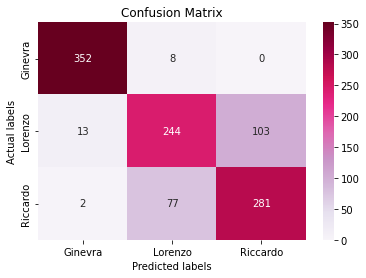

In [ ]:
# predizioni sul training
y_pred = clf_svm.predict(X_train)
evaluate_prediction(y_train, y_pred)


Classification Report
               precision    recall  f1-score   support

     Ginevra       0.93      0.95      0.94        40
     Lorenzo       0.68      0.75      0.71        40
    Riccardo       0.80      0.70      0.75        40

    accuracy                           0.80       120
   macro avg       0.80      0.80      0.80       120
weighted avg       0.80      0.80      0.80       120





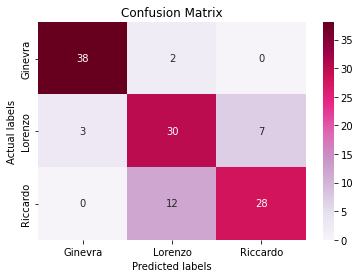

In [ ]:
# predizioni sul test set
y_pred = clf_svm.predict(X_test)
evaluate_prediction(y_test, y_pred)

Possiamo notare come i risultati siano molto vicini, quindi la rete non sembra essere soggetta ad overfitting particolare. Inoltre possiamo notare che le classi più confuse sono 'Lorenzo' e 'Riccardo', mentre 'Ginevra' viene classificata con molta più accuratezza. Questo può essere dovuto al fatto che è l'unica voce femminile. <br>
Salviamo quindi il modello per poterlo poi ricaricare se necessario.

In [ ]:
# salvataggio del modello su drive
pickle.dump(clf_svm, open(MODEL_PATH + 'svm.pkl', 'wb'))

### Classificazione audio con SVM con dati normalizzati
Utilizzando lo stesso approccio precedente valutiamo le performance di SVM normalizzando i dati.<br>
Rivalutiamo quindi i diversi features extractor per i dati normalizzati.

In [ ]:
# Dizionario feature extractor-accuracy SVM
extr_acc_svm = find_opt_extractor('./audio_cropped/', extractors,
                                  clf_str = 'svm', normalize = True)
extr_acc_svm

{'Function combo1': 0.9083333333333333,
 'Function combo2': 0.44166666666666665,
 'Function combo3': 0.9166666666666666,
 'Function mfcc': 0.9166666666666666,
 'Function rmse': 0.44166666666666665,
 'Function sdev': 0.425,
 'Function spectral_centroids': 0.4166666666666667,
 'Function zcr': 0.4166666666666667}

In questo caso possiamo notare che `combo3` e `mfcc` ottengono le stesse performance. Come in precedenza decidiamo di utilizzare la sola features `mfcc`. <br>
Ricarichiamo quindi i subset di training e test con la nuova features e con l'opzione di normalizzazione settata a true.

In [ ]:
# carichiamo i subset, type_class = 'ml' per ottenere la versione flatten delle features
# necessaria per evitare errori con la SVM. Inoltre utilizziamo la normalizzazione
X_train, X_test, y_train, y_test = load_data('./audio_cropped/',
                                             feature_extractor = mfcc,
                                             type_class = 'ml', normalize = True)

Effettuiamo una nuova ricerca dei parametri migliori.

In [ ]:
# creo una griglia di parametri su cui effettuare la ricerca
param_grid = {'C': [1, 5, 10, 12, 15, 18],
              'gamma': [1e-12, 1e-09, 0.0001, 0.0004, 0.0006, 0.0008, 0.001]}

# addestro il classificatore come una SVM sfruttando la grid search
clf_svm_norm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                            param_grid, cv = 3)

# fittiamo il modello coi parametri trovati
clf_svm_norm = clf_svm_norm.fit(X_train, y_train)

Visualizziamo i migliori parametri individuati

In [ ]:
print('I parametri migliori ottenuti sono: \n')
print(clf_svm_norm.best_estimator_)

I parametri migliori ottenuti sono: 

SVC(C=10, class_weight='balanced', gamma=0.0006)


Si può notare che i parametri sono cambiati rispetto al caso precedente. \
Come in precedenza valutiamo il modello su training e test set.


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      1.00      1.00       360
     Lorenzo       1.00      1.00      1.00       360
    Riccardo       1.00      1.00      1.00       360

    accuracy                           1.00      1080
   macro avg       1.00      1.00      1.00      1080
weighted avg       1.00      1.00      1.00      1080





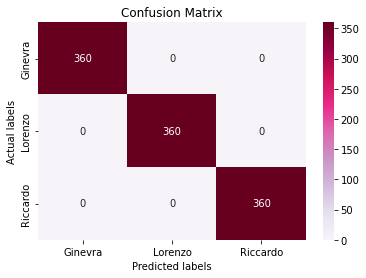

In [ ]:
# valutazione modello sul traning
y_pred = clf_svm_norm.predict(X_train)
evaluate_prediction(y_train, y_pred)


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      0.95      0.97        40
     Lorenzo       0.90      0.90      0.90        40
    Riccardo       0.90      0.95      0.93        40

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120





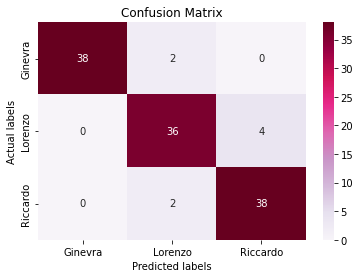

In [ ]:
# valutazione modello sul test
y_pred = clf_svm_norm.predict(X_test)
evaluate_prediction(y_test, y_pred)

Possiamo notare che in questo caso l'accuracy finale è migliorata rispetto al caso senza normalizzazione. Tuttavia il modello sembra essere in overfitting rispetto ai dati di training. <br>
Procediamo con il salvataggio dei modelli.

In [ ]:
# salviamo il modello
pickle.dump(clf_svm_norm, open(MODEL_PATH + 'svm_norm.pkl', 'wb'))

### Classificazione audio con SVM con dati aumentati
L'ultimo tentativo che testiamo utilizza i dati aumentati senza normalizzazione. Per vedere se aumentando i dati migliora l'accuratezza finale. Inoltre sfruttanto i dati aumentati si spera di creare un modello più robusto a variazioni (es: cambio nella velocità di pronuncia).<br>
Valutiamo quindi i diversi features extractor.

In [ ]:
# Dizionario feature extractor-accuracy SVM
extr_acc_svm = find_opt_extractor('./audio_crop_aug/', extractors,
                                  clf_str = 'svm')
extr_acc_svm

{'Function combo1': 0.8270833333333333,
 'Function combo2': 0.4791666666666667,
 'Function combo3': 0.5270833333333333,
 'Function mfcc': 0.8270833333333333,
 'Function rmse': 0.53125,
 'Function sdev': 0.4270833333333333,
 'Function spectral_centroids': 0.48541666666666666,
 'Function zcr': 0.36875}

Come per i casi precedenti utilizziamo il solo `mfcc`. Procediamo quindi a ricaricare i dati.

In [ ]:
# caricamento dei dati in training e test. In questo caso utilizziamo quelli AUMENTATI
X_train, X_test, y_train, y_test = load_data('./audio_crop_aug/',
                                             feature_extractor = mfcc,
                                             type_class = 'ml')

Si effettua quindi la ricerca dei migliori parametri per SVM

In [ ]:
# creo una griglia di parametri su cui effettuare la ricerca
param_grid = {'C': [1, 5, 10, 12, 15, 18],
              'gamma': [1e-12, 1e-09, 0.0001, 0.0004, 0.0006, 0.0008, 0.001]}

# addestro il classificatore come una SVM sfruttando la grid search
clf_svm_augm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                            param_grid, cv = 3)

# fittiamo il modello con i migliori parametri trovati
clf_svm_augm = clf_svm_augm.fit(X_train, y_train)

In [ ]:
print('I parametri migliori ottenuti sono: \n')
print(clf_svm_augm.best_estimator_)

I parametri migliori ottenuti sono: 

SVC(C=18, class_weight='balanced', gamma=1e-09)


Si può notare che i parametri sono cambiati rispetto al caso precedente. <br>
Valutiamo le performance ottenute dal modello su training e test set.


Classification Report
               precision    recall  f1-score   support

     Ginevra       0.92      0.97      0.94      1440
    Riccardo       0.81      0.81      0.81      1440
     Lorenzo       0.86      0.82      0.84      1440

    accuracy                           0.86      4320
   macro avg       0.86      0.86      0.86      4320
weighted avg       0.86      0.86      0.86      4320





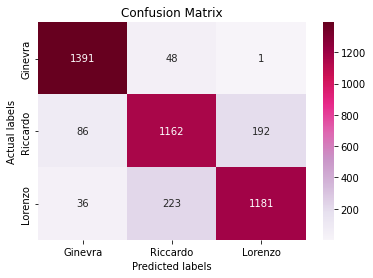

In [ ]:
# valutazione modello sul traning
y_pred = clf_svm_augm.predict(X_train)
evaluate_prediction(y_train, y_pred)


Classification Report
               precision    recall  f1-score   support

     Ginevra       0.89      0.96      0.92       160
    Riccardo       0.79      0.74      0.77       160
     Lorenzo       0.82      0.79      0.81       160

    accuracy                           0.83       480
   macro avg       0.83      0.83      0.83       480
weighted avg       0.83      0.83      0.83       480





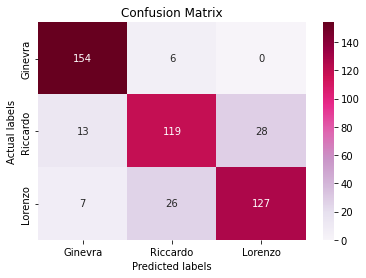

In [ ]:
# valutazione modello sul test
y_pred = clf_svm_augm.predict(X_test)
evaluate_prediction(y_test, y_pred)

Si può notare che l'accuracy migliora rispetto alla prima SVM implementata e non sembra esserci un forte overfitting nel training. Quindi si ritiene essere questa la versione migliore dato che la versione normalizzata ottiene accuracy migliore però è sicuramente in overfitting.

In [ ]:
# salvataggio del modello
pickle.dump(clf_svm_augm, open(MODEL_PATH + 'svm_augm.pkl', 'wb'))

## Modelli **Random Forest**
Il secondo classificatore che si è scelto di implementare è il random forest. Si è scelto questo classificatore perchè implementa una struttura ad albero e quindi utilizza logiche diverse rispetto ad SVM. Come per il precedente classificatore verranno realizzate diverse versioni:


*   Consideranto i soli audio da due secondi
*   Applicando la normalizzazione agli audio da due secondi
* Utilizzando gli audio nella versione aumentata.


### Classificazione audio con RF
Il primo classificatore che testiamo utilizza i dati tagliati ogni due secondi. Prima di applicare il fitting vero e proprio utilizziamo la funzione definita in precedenza per individuare il miglior estrattore tra i diversi implementati.

In [ ]:
# Ricerchiamo le features migliori
extr_acc_rf = find_opt_extractor('./audio_cropped/', extractors,
                                  clf_str = 'rf')
extr_acc_rf

{'Function combo1': 0.6833333333333333,
 'Function combo2': 0.44166666666666665,
 'Function combo3': 0.675,
 'Function mfcc': 0.7166666666666667,
 'Function rmse': 0.325,
 'Function sdev': 0.3416666666666667,
 'Function spectral_centroids': 0.425,
 'Function zcr': 0.39166666666666666}

Analizzando i risultati è possibile verificare come `mfcc` sia la features che restituisce la miglior accuratezza. Procediamo quindi a ricaricare i dati utilizzando questo features extractor. Anche in questo caso utilizziamo la versione flatten dei dati per poterli utilizzare correttamente nel classificatore random forest. <br>
Rispetto a prima inoltre le label vengono codificare in numero attraverso il metodo di LabelEncored().

In [ ]:
# carichiamo i dati usando MFCC
X_train, X_test, y_train, y_test = load_data('./audio_cropped/',
                                             feature_extractor = mfcc,
                                             type_class = 'ml')

# codifica delle label di training in numero
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
# codifica delle label di test in numero
le.fit(y_test)
y_test = le.transform(y_test)

Effettuiamo quindi un gridsearch sui parametri del randomForest per individuarne i migliori.

In [ ]:
# creo una griglia di parametri su cui effettuare la ricerca
param_grid = {'n_estimators': [50, 65, 80, 100],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,6,8,10,12]}

# addestro il classificatore come una SVM sfruttando la grid search
clf_rf = GridSearchCV(RandomForestRegressor(random_state=1),
                       param_grid, cv = 3)

clf_rf = clf_rf.fit(X_train, y_train)

In [ ]:
print('I parametri migliori ottenuti sono: \n')
print(clf_rf.best_params_)

I parametri migliori ottenuti sono: 

{'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100}


Calcoliamo le predizioni su training e test set per verificare le performance e se vi sia o meno overfitting.


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      0.99      1.00       360
     Lorenzo       0.99      1.00      1.00       360
    Riccardo       1.00      1.00      1.00       360

    accuracy                           1.00      1080
   macro avg       1.00      1.00      1.00      1080
weighted avg       1.00      1.00      1.00      1080





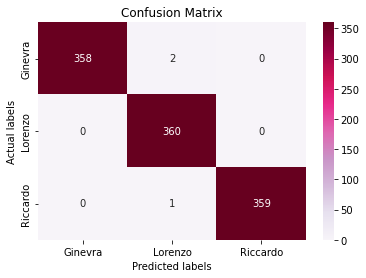

In [ ]:
# calcoliamo le predizioni
y_pred = clf_rf.predict(X_train)
# convertiamo le predizioni ad intero
y_pred = np.around(y_pred).astype(int)
evaluate_prediction(y_train, y_pred)


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      0.65      0.79        40
     Lorenzo       0.54      0.97      0.70        40
    Riccardo       0.95      0.53      0.68        40

    accuracy                           0.72       120
   macro avg       0.83      0.72      0.72       120
weighted avg       0.83      0.72      0.72       120





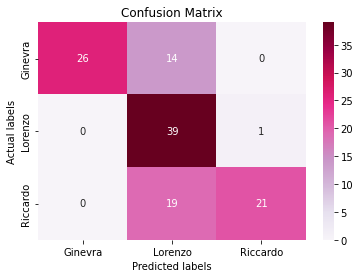

In [ ]:
y_pred = clf_rf.predict(X_test)
# convertiamo le predizioni ad intero
y_pred = np.around(y_pred).astype(int)
evaluate_prediction(y_test, y_pred)

Possiamo verificare che l'accuratezza sul test set non è particolarmente alta e sicuramente inferiore rispetto alla SVM. Inoltre la rete sembra essere in forte overfitting sui dati di training!

In [ ]:
# salviamo il modello
pickle.dump(clf_rf, open(MODEL_PATH + 'rf.pkl', 'wb'))

### Classificazione audio con RF con dati normalizzati

In [ ]:
# Ricerchiamo le features migliori
extr_acc_rf = find_opt_extractor('./audio_cropped/', extractors,
                                  clf_str = 'rf', normalize = True)
extr_acc_rf

{'Function combo1': 0.6833333333333333,
 'Function combo2': 0.44166666666666665,
 'Function combo3': 0.675,
 'Function mfcc': 0.7166666666666667,
 'Function rmse': 0.325,
 'Function sdev': 0.3416666666666667,
 'Function spectral_centroids': 0.425,
 'Function zcr': 0.4}

Analizzando i risultati è possibile verificare come `mfcc` sia la features che restituisce la miglior accuratezza. Procediamo quindi a ricaricare i dati utilizzando questo features extractor. Come prima si utilizza la versione flatten dei dati e l'encoder per le label.

In [ ]:
# carichiamo i dati usando MFCC con normalizzazione!
X_train, X_test, y_train, y_test = load_data('./audio_cropped/',
                                             feature_extractor = mfcc,
                                             type_class = 'ml', normalize = True)

# codifica delle label di training in numero
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
# codifica delle label di test in numero
le.fit(y_test)
y_test = le.transform(y_test)

Effettuiamo nuovamente il gridsearch per individuare i parametri migliori

In [ ]:
# creo una griglia di parametri su cui effettuare la ricerca
param_grid = {'n_estimators': [50, 80, 100],
              'max_features': ['auto', 'sqrt'],
              'max_depth' : [4,8,10,12]}

# addestro il classificatore come una SVM sfruttando la grid search
clf_rf_norm = GridSearchCV(RandomForestRegressor(random_state=1),
                           param_grid, cv = 3)

clf_rf_norm = clf_rf_norm.fit(X_train, y_train)

In [ ]:
print('I parametri migliori ottenuti sono: \n')
print(clf_rf_norm.best_params_)

I parametri migliori ottenuti sono: 

{'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100}


Si può notare che in questo caso non vi è alcun cambiamento nei parametri. <br>
Calcoliamo le predizioni su training e test set per verificare le performance e se vi sia o meno overfitting.


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      0.99      1.00       360
     Lorenzo       0.99      1.00      1.00       360
    Riccardo       1.00      1.00      1.00       360

    accuracy                           1.00      1080
   macro avg       1.00      1.00      1.00      1080
weighted avg       1.00      1.00      1.00      1080





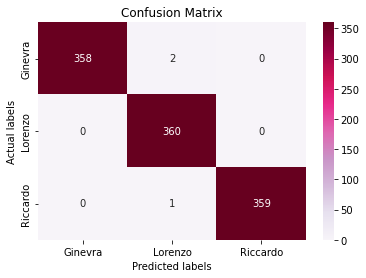

In [ ]:
y_pred = clf_rf_norm.predict(X_train)
# convertiamo le predizioni in intero
y_pred = np.around(y_pred).astype(int)
evaluate_prediction(y_train, y_pred)


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      0.65      0.79        40
     Lorenzo       0.54      0.97      0.70        40
    Riccardo       0.95      0.53      0.68        40

    accuracy                           0.72       120
   macro avg       0.83      0.72      0.72       120
weighted avg       0.83      0.72      0.72       120





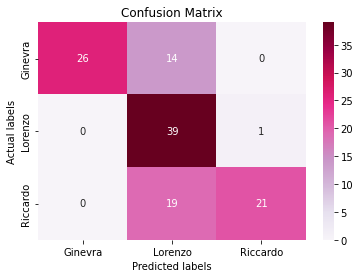

In [ ]:
y_pred = clf_rf_norm.predict(X_test)
# convertiamo le predizioni in intero
y_pred = np.around(y_pred).astype(int)
evaluate_prediction(y_test, y_pred)

Con i dati normalizzati non si ottengono particolari miglioramenti nelle performance. Inoltre si è nuovamente in casisistica di overfitting sul training.

In [ ]:
# salvataggio del modello
pickle.dump(clf_rf_norm, open(MODEL_PATH + 'rf_norm.pkl', 'wb'))

### Classificazione audio con RF con dati aumentati

Da questi risultati possiamo dedurre che il miglior approccio per estrarre le features da addestrare con SVM sia `combo1` oppure `mfcc`. Per le features da addestrare con Random Forest, i risultati sono simili: otteniamo buoni risultati sia con `combo1` che `combo2`, ma anche con `mfcc` l'accuratezza è elevata.

In [ ]:
# Ricerchiamo le features migliori
extr_acc_rf = find_opt_extractor('./audio_crop_aug/', extractors,
                                  clf_str = 'rf')
extr_acc_rf

{'Function combo1': 0.7895833333333333,
 'Function combo2': 0.55,
 'Function combo3': 0.7979166666666667,
 'Function mfcc': 0.8,
 'Function rmse': 0.37916666666666665,
 'Function sdev': 0.3729166666666667,
 'Function spectral_centroids': 0.5145833333333333,
 'Function zcr': 0.30833333333333335}

Analizzando i risultati è possibile verificare come `mfcc` sia la features che restituisce la miglior accuratezza. Procediamo quindi a ricaricare i dati utilizzando questo features extractor. Come prima si utilizza la versione flatten dei dati e l'encoder per le label.

In [ ]:
# carichiamo i dati AUMENTATI usando MFCC
X_train, X_test, y_train, y_test = load_data('./audio_crop_aug/',
                                             feature_extractor = mfcc,
                                             type_class = 'ml')

# codifica delle label di training in numero
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
# codifica delle label di test in numero
le.fit(y_test)
y_test = le.transform(y_test)

Come prima utilizziamo GridSearch per individuare i parametri.

In [ ]:
# creo una griglia di parametri su cui effettuare la ricerca
param_grid = {'n_estimators': [50, 80, 100],
              'max_features': ['auto', 'sqrt'],
              'max_depth' : [4,8,10,12]}

# addestro il classificatore come una SVM sfruttando la grid search
clf_rf_augm = GridSearchCV(RandomForestRegressor(random_state=1),
                           param_grid, cv = 3)

clf_rf_augm = clf_rf_augm.fit(X_train, y_train)

In [ ]:
print('I parametri migliori ottenuti sono: \n')
print(clf_rf_augm.best_params_)

I parametri migliori ottenuti sono: 

{'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100}


Nuovamente si può notare come i parametri siano gli stessi. <br>
Calcoliamo le predizioni su training e test set per verificare le performance e se vi sia o meno overfitting.


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      0.97      0.99      1440
     Lorenzo       0.95      1.00      0.97      1440
    Riccardo       1.00      0.98      0.99      1440

    accuracy                           0.98      4320
   macro avg       0.98      0.98      0.98      4320
weighted avg       0.98      0.98      0.98      4320





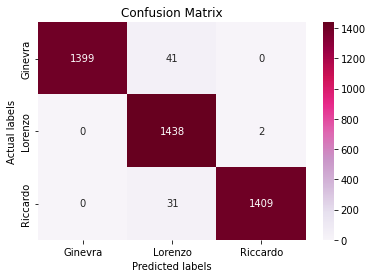

In [ ]:
# calcoliamo le predizioni
y_pred = clf_rf_augm.predict(X_train)
# convertiamo le predizioni ad intero
y_pred = np.around(y_pred).astype(int)
evaluate_prediction(y_train, y_pred)


Classification Report
               precision    recall  f1-score   support

     Ginevra       0.98      0.78      0.87       160
     Lorenzo       0.65      0.96      0.77       160
    Riccardo       0.96      0.70      0.81       160

    accuracy                           0.81       480
   macro avg       0.86      0.81      0.82       480
weighted avg       0.86      0.81      0.82       480





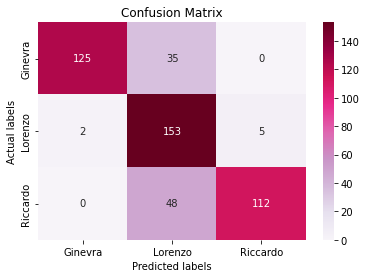

In [ ]:
# calcoliamo le predizioni sul test
y_pred = clf_rf_augm.predict(X_test)
# convertiamo le predizioni ad intero
y_pred = np.around(y_pred).astype(int)
evaluate_prediction(y_test, y_pred)

Si può osservare come l'utilizzo dei dati aumentati permetta di migliorare le performance. Tuttavia persiste il problema dell'overfitting.

In [ ]:
# salviamo il modello
pickle.dump(clf_rf_augm, open(MODEL_PATH + 'rf_augm.pkl', 'wb'))

## Valutazione SVM e RF
In questa sezione abbiamo testato i modelli implementati precedentemente su file audio da $5 \text{s}$ registrati durante conversazioni quotidiane, non durante la lettura di un libro o una rivista. <br>
In particolare abbiamo selezionato i due classificatori SVM e RF addestrati sui dati segmentati e aumentati e di seguito riportiamo i risultati. <br>
Facciamo notare che i tempi di esecuzione della classificazione sono notevolmente più rapidi per SVM rispetto a RF.

In [ ]:
svm = pickle.load(open(MODEL_PATH + 'svm_augm.pkl', 'rb'))
rf = pickle.load(open(MODEL_PATH + 'rf_augm.pkl', 'rb'))

In [ ]:
path_wild = DRIVE_PATH + 'Data/audio/test_wild/'

La funzione `evaluationWild(model, path, type_class)` applica una classificazione attraverso il modello `model` sui dati raccolti in `path` e croppati mediante la chiamata a funzione `crop(signal, multi = True)`. Stampa a video le predizioni svolte su ogni segmento rispetto alla *true label*, estratta dal nome del file *.wav*.

In [ ]:
def evaluationWild(model, path, type_class):

  print('True Label: ', '\t', '\t',
        'Segmento numero: ', '\t', '\t',
        'Label predetta: ')
  count_true = 0
  tot_segs = 0

  for f in sorted(os.listdir(path)):
    if f.endswith('.wav'):
      
      _, signal = wav.read(path + f)
      signals = crop(signal, multi = True)
      count_seg = 0
      y_true = f.split('_')[0]

      for seg in signals:
        count_seg += 1
        tot_segs += 1

        # se il classificatore è SVM
        if type_class == 'svm':

          ff = mfcc(seg).flatten()
          y_pred = model.predict(ff.reshape(-1, ff.shape[0]))[0]
        # se il classificatore è Random Forest
        elif type_class == 'rf':

          ff = mfcc(seg).flatten()
          y_pred = model.predict(ff.reshape(-1, ff.shape[0]))

          if np.around(y_pred).astype(int) == int(0):
            y_pred = 'Ginevra'
          elif np.around(y_pred).astype(int) == int(1):
            y_pred = 'Lorenzo'
          else:
            y_pred = 'Riccardo'
        # se il classificatore è una rete neurale
        elif type_class == 'nn':
          # estraggo le features mfcc per il modello
          ff = mfcc(seg)

          # adatto la shape
          ff = np.array(ff).reshape(-1,ff.shape[0],ff.shape[1],1)

          # Estraggo la predizione su un singolo file
          y_pred = model.predict(ff)
          # estraggo il numero di riferimento della label
          y_pred = np.argmax(y_pred, axis=1)[0]

          if y_pred == 0:
            y_pred = 'Ginevra'
          elif y_pred == 1:
            y_pred = 'Lorenzo'
          else:
            y_pred = 'Riccardo'
        elif type_class == 'spect':
          wav.write('./temp_file.wav', 44100, seg)
          img = get_spectrogram('./temp_file.wav', (64,64))
          image = np.expand_dims(img, axis = 0)

          y_pred = model.predict(image)
          # estraggo il singolo autore
          y_pred = np.argmax(y_pred, axis = 1)

          if y_pred == 0:
            y_pred = 'Ginevra'
          elif y_pred == 1:
            y_pred = 'Lorenzo'
          else:
            y_pred = 'Riccardo'


        if y_true == y_pred:
          count_true += 1
        
        print(' ', y_true, '\t', '\t', '\t',
              str(count_seg), '\t', '\t', '\t',
              '   ', y_pred)

        if count_seg == len(signals):
          print('  --------', '\t', '\t',
                '       ---', '\t', '\t', '\t',
                '    --------')

  print('\n Audio totali: ', str(len(os.listdir(path))), '\n',
        'Numero toatle segmenti: ', str(tot_segs), '\n',
        'Segmenti predetti correttamente: ', str(count_true), '\n')

In [ ]:
%%time
evaluationWild(svm, path_wild, type_class = 'svm')

True Label:  	 	 Segmento numero:  	 	 Label predetta: 
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------

Come si poteva immaginare i risultati che il classificatore SVM ottiene su dati registrati fuori dal contesto della lettura, nonostante il modello sia stato addestrato su dati aumentati, sono peggiori rispetto alla valutazione svolta nelle sezioni precedenti sul test set. L'accuratezza ottenuta sui dati "*wild*" raggiunge il $74\%$ con un tempo di esecuzione totale di circa $3 \text{s}$.

In [ ]:
%%time
evaluationWild(rf, path_wild, type_class = 'rf')

True Label:  	 	 Segmento numero:  	 	 Label predetta:  	
  Ginevra 	 	 	 1 	 	 	     Lorenzo
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	   	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	   	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	   	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	   	     --------
  Ginevra 	 	 	 1 	 	 	     Lorenzo
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Lorenzo
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	   	 

Così come per il classificatore precedente, anche RF valutato su dati generati da un contesto diverso da quello originale ottiene risultati peggiori, con un'accuratezza pari a $56\%$. <br>
Come anticipato poco fa, si può nuovamente osservare come la classificazione di Random Forest svolta sui medesimi dati sia più lenta di circa $1 \text{s}$.

## Classificazione audio con **Neural Network**
Il terzo approccio consiste nell'implementazione di alcune reti neurali. Una prima versione utilizza come input le features estratte con `mfcc`, mentre la seconda prende in input le immagini degli spettogrammi degli audio che verranno opportunamente create.

### Classificazione basata su mfcc
Definiamo un modello che prenda in input le features generate da mfcc. Questo modello utilizza alcuni layer convoluzionali 2D i cui iperparametri sono stati selezionati a seguito di alcune prove in cui sono risultati essere i più performanti.<br>
Carichiamo quindi i dati croppati a due secondi con la features mfcc.

In [ ]:
# scarico lo zip di training con i soli audio croppati a 2 secondi
load_zip(DRIVE_PATH + 'Data/audio/audio_cropped.tar', 'audio_cropped.tar')

In [ ]:
# creo i dataset di train e test sfruttanto la funzione di load_data definita sopra
X_train, X_test, y_train, y_test = load_data('./audio_cropped/', mfcc)

Per poter utilizzare correttamente i dati è necessario convertire la label e effettuare un reshaping dei dati.

In [ ]:
# ridefinisco la shape di X_train e X_test per poterli utilizzare correttamente 
# coi modelli keras
X_train = np.array(X_train).reshape(-1,X_train[0].shape[0],X_train[0].shape[1],1)
X_test = np.array(X_test).reshape(-1,X_test[0].shape[0],X_test[0].shape[1],1)

# effettuo l'encoding delle label per rappresentarle come numeri [0,1,2]
le = LabelEncoder()
# Train
le.fit(y_train)
y_train = keras.utils.to_categorical(le.transform(y_train))
# Test
le.fit(y_test)
y_test = keras.utils.to_categorical(le.transform(y_test))

Definiamo la funzione che permette di costruire il modello

In [ ]:
def build_scratch():
  # definisco l'input
  input_layer=Input(shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]))

  # definisco i primi layer convoluzionali
  x= Conv2D(32, kernel_size=(3,3), activation='relu')(input_layer)
  x= Conv2D(32, kernel_size=(3,3), activation='relu')(x)
  x= Dropout(0.3)(x)
  x= MaxPooling2D(pool_size=(2,2))(x)
  
  x= Flatten()(x)

  # layer finali fully connected
  x= Dense(16, activation='relu')(x)
  #x= Dropout(0.1)(x)
  x= Dense(16, activation='relu')(x)
  #x= Dropout(0.1)(x)

  # Output layer
  out_layer = Dense(3, activation='softmax')(x)

  # Costruzione modello
  model = Model(inputs = input_layer, outputs = out_layer)

  # Compilazione modello
  model.compile(loss = categorical_crossentropy,
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])
  
  return model

Come si può notare dal summay questo modello utilizza pochi parametri, $181.939$.

In [ ]:
model_scrach = build_scratch()
model_scrach.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 173, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 11, 171, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 169, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 9, 169, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 84, 32)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 10752)             0         
                                                             

Visualizziamo graficamente il modello.

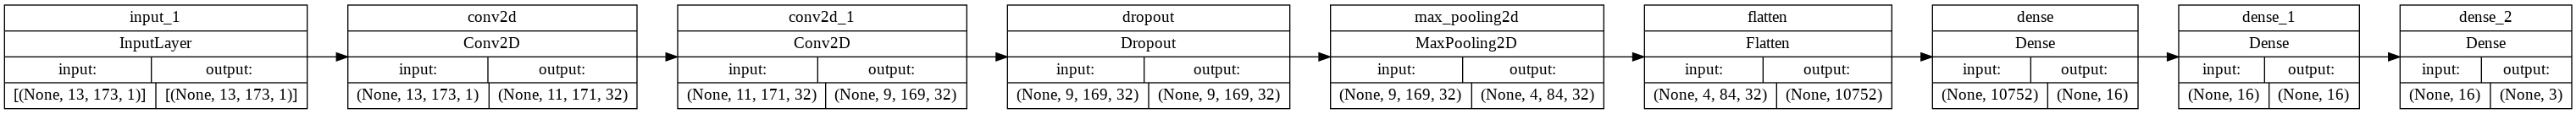

In [ ]:
keras.utils.plot_model(model_scrach, rankdir='LR', show_shapes=True)

Effettuiamo quindi il training del modello settando come massimo $100$ epoche e utilizzando la tecnica dell'EarlyStopping per fermare l'apprendimento dopo tre epoche senza miglioramenti. <br>
Si è scelto di utilizzare comunque uno split di $15%$ come validation e preservare così una porzione di dati per un'ulteriore test.

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.001, 
                           verbose = 1, restore_best_weights = True) 

hist_scratch = model_scrach.fit(X_train, y_train, epochs=100, batch_size=16,
                                validation_split = 0.15, verbose=1, 
                                callbacks = [early_stop])

Epoch 1/100
51/51 [==============================] - 8s 134ms/step - loss: 1.3270 - accuracy: 0.3750 - val_loss: 1.1260 - val_accuracy: 0.2986
Epoch 2/100
51/51 [==============================] - 4s 82ms/step - loss: 1.0121 - accuracy: 0.4265 - val_loss: 0.9278 - val_accuracy: 0.5833
Epoch 3/100
51/51 [==============================] - 4s 82ms/step - loss: 0.8136 - accuracy: 0.6262 - val_loss: 0.7860 - val_accuracy: 0.6875
Epoch 4/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6317 - accuracy: 0.7537 - val_loss: 0.5302 - val_accuracy: 0.8264
Epoch 5/100
51/51 [==============================] - 4s 83ms/step - loss: 0.4697 - accuracy: 0.8272 - val_loss: 0.4064 - val_accuracy: 0.8889
Epoch 6/100
51/51 [==============================] - 4s 82ms/step - loss: 0.3802 - accuracy: 0.8480 - val_loss: 0.3945 - val_accuracy: 0.8542
Epoch 7/100
51/51 [==============================] - 4s 82ms/step - loss: 0.3073 - accuracy: 0.8836 - val_loss: 0.3883 - val_accuracy: 0.8472
Epoch

Visualizziamo l'andamento del training.

Numero di epoche totali: 26
Epoca migliore (weights restored): 23
Accuracy training set all'epoca 23: 0.9975489974021912
Accuracy validation set all'epoca 23: 0.9513888955116272
Loss training set all'epoca 23: 0.01972508430480957
Loss validation set all'epoca 23: 0.09749094396829605





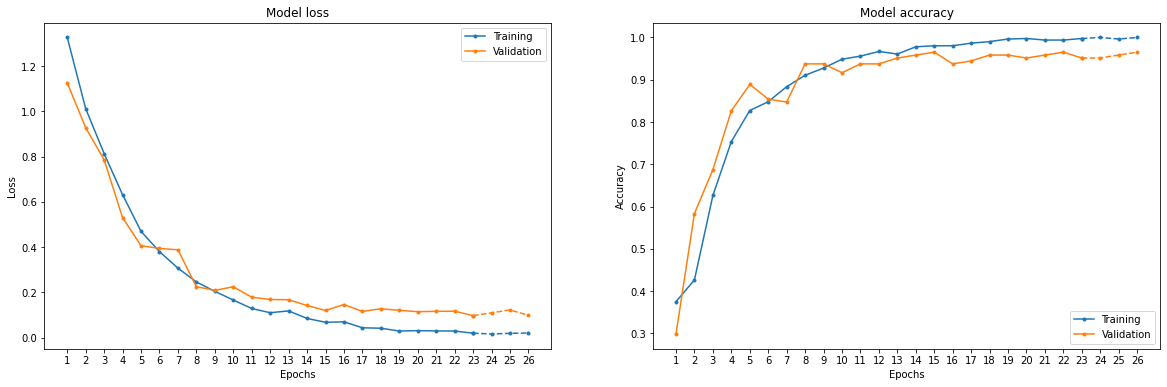

In [ ]:
resume_model_history(hist_scratch, early_stop)

Dall'andamento sembra esserci un leggero overfitting a partire dall'epoca $10$! I valori di performance sia per loss che accuracy sembra comunque essere molto buoni sul validation. <br>
Valutiamo quindi le performance sul test.

In [ ]:
# salvataggio del modello
model_scrach.save(MODEL_PATH + 'scratch.h5')

Valutiamo le performance sul test set precedentemente preservato.


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      1.00      1.00        40
     Lorenzo       0.95      0.95      0.95        40
    Riccardo       0.95      0.95      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120





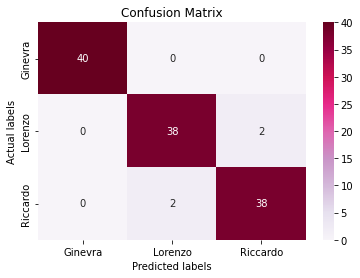

In [ ]:
# se necessario ricarico il modello da drive
model_scrach = keras.models.load_model(MODEL_PATH + 'scratch.h5')

# prediction for test set
y_hat = model_scrach.predict(X_test)
# get the label correspoinding to the top score
y_hat = np.argmax(y_hat, axis=1)

# Convert one-hot encoding to integer value
y_test = y_test.argmax(axis = 1)

# valuto il modello sul test set
evaluate_prediction(y_test, y_hat)

I risultati sono in linea con quanto visto nel validation. Inoltre possiamo osservare che gli errori sono tra 'Lorenzo' e 'Riccardo' mentre 'Ginevra' viene predetta correttamente in ogni audio.

### Modello con mfcc e dati aumentati
Viene fatto un tentativo implementando una rete anche con i dati aumentati.

In [ ]:
# scarico lo zip di training con i soli audio croppati a 2 secondi
load_zip(DRIVE_PATH + 'Data/audio/audio_crop_aug.tar', 'audio_crop_aug.tar')

In [ ]:
# creo i dataset di train e test sfruttanto la funzione di load_data definita sopra
X_train, X_test, y_train, y_test = load_data('./audio_crop_aug/', mfcc)

Per poter utilizzare correttamente i dati è necessario convertire la label e effettuare un reshaping dei dati.

In [ ]:
# ridefinisco la shape di X_train e X_test per poterli utilizzare correttamente 
# coi modelli keras
X_train = np.array(X_train).reshape(-1,X_train[0].shape[0],X_train[0].shape[1],1)
X_test = np.array(X_test).reshape(-1,X_test[0].shape[0],X_test[0].shape[1],1)

# effettuo l'encoding delle label per rappresentarle come numeri [0,1,2]
le = LabelEncoder()
# Train
le.fit(y_train)
y_train = keras.utils.to_categorical(le.transform(y_train))
# Test
le.fit(y_test)
y_test = keras.utils.to_categorical(le.transform(y_test))

In [ ]:
def build_scratch_aug():
  # definisco l'input
  input_layer=Input(shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]))

  # definisco i primi layer convoluzionali
  x= Conv2D(32, kernel_size=(3,3), activation='relu')(input_layer)
  x= Conv2D(32, kernel_size=(3,3), activation='relu')(x)
  x= Dropout(0.45)(x)
  x= MaxPooling2D(pool_size=(2,2))(x)
  
  x= Flatten()(x)

  # layer finali fully connected
  x= Dense(16, activation='relu')(x)
  #x= Dropout(0.1)(x)
  x= Dense(16, activation='relu')(x)
  #x= Dropout(0.1)(x)

  # Output layer
  out_layer = Dense(3, activation='softmax')(x)

  # Costruzione modello
  model = Model(inputs = input_layer, outputs = out_layer)

  # Compilazione modello
  model.compile(loss = categorical_crossentropy,
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])
  
  return model

Dal summary della rete è possibile notare che il numero di parametri è molto simile alla rete precedente.

In [ ]:
model_augm = build_scratch_aug()
model_augm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13, 173, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 171, 32)       320       
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 169, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 9, 169, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 84, 32)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 10752)             0         
                                                           

Effettuiamo l'addestramento con le medesime configurazioni precedenti.

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.001, 
                           verbose = 1, restore_best_weights = True) 

hist_augm = model_augm.fit(X_train, y_train, epochs=100, batch_size=16,
                           validation_split = 0.15, verbose=1, 
                           callbacks = [early_stop])

Epoch 1/100
204/204 [==============================] - 17s 82ms/step - loss: 1.2517 - accuracy: 0.5392 - val_loss: 0.6261 - val_accuracy: 0.7135
Epoch 2/100
204/204 [==============================] - 16s 81ms/step - loss: 0.5634 - accuracy: 0.7347 - val_loss: 0.4951 - val_accuracy: 0.7969
Epoch 3/100
204/204 [==============================] - 17s 82ms/step - loss: 0.4455 - accuracy: 0.7996 - val_loss: 0.4196 - val_accuracy: 0.8108
Epoch 4/100
204/204 [==============================] - 18s 86ms/step - loss: 0.3674 - accuracy: 0.8395 - val_loss: 0.3570 - val_accuracy: 0.8542
Epoch 5/100
204/204 [==============================] - 16s 81ms/step - loss: 0.2947 - accuracy: 0.8778 - val_loss: 0.2951 - val_accuracy: 0.8802
Epoch 6/100
204/204 [==============================] - 19s 94ms/step - loss: 0.2529 - accuracy: 0.8949 - val_loss: 0.2902 - val_accuracy: 0.8872
Epoch 7/100
204/204 [==============================] - 17s 81ms/step - loss: 0.2258 - accuracy: 0.9075 - val_loss: 0.2517 - val_ac

Visualizziamo quindi l'andamento del training del modello.

Numero di epoche totali: 22
Epoca migliore (weights restored): 19
Accuracy training set all'epoca 19: 0.9742646813392639
Accuracy validation set all'epoca 19: 0.9392361044883728
Loss training set all'epoca 19: 0.06627331674098969
Loss validation set all'epoca 19: 0.1480238288640976





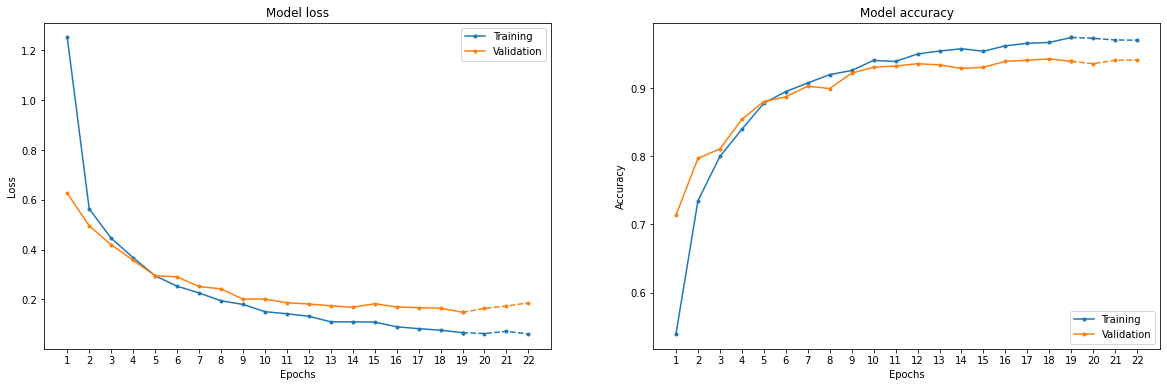

In [ ]:
resume_model_history(hist_augm, early_stop)

In [ ]:
# salvataggio del modello
model_augm.save(MODEL_PATH + 'scratch_augm.h5')


Classification Report
               precision    recall  f1-score   support

     Ginevra       0.91      0.99      0.95       160
     Lorenzo       0.92      0.89      0.90       160
    Riccardo       0.95      0.89      0.92       160

    accuracy                           0.92       480
   macro avg       0.92      0.92      0.92       480
weighted avg       0.92      0.92      0.92       480





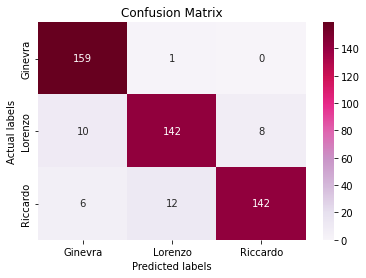

In [ ]:
# se necessario ricarico il modello da drive
model_scrach = keras.models.load_model(MODEL_PATH + 'scratch_augm.h5')

# prediction for test set
y_hat = model_scrach.predict(X_test)
# get the label correspoinding to the top score
y_hat = np.argmax(y_hat, axis=1)

# Convert one-hot encoding to integer value
y_test = y_test.argmax(axis = 1)

# valuto il modello sul test set
evaluate_prediction(y_test, y_hat)

### Classificazione con **spettrogramma**
L'analisi dello spettro fornisce una vasta gamma di informazioni sui segnali. Lo **spettrogramma** di un segnale audio è una rappresentazione visiva di come lo spettro delle frequenze di un segnale audio varia nel tempo. Si passa quindi da segnali monodimensionali a segnali bidimensionali (immagini) che andremo a classificare attraverso una rete neurale convoluzionale implementata "*from scratch*".

#### Funzioni ausiliari
In questa sezione vengono raccolte le funzioni necessarie per creare gli spettrogrammi.
Seguono una funzione per la generazione di uno spettrogramma a partire da un audio ed una che itera la funzione descritta all'interno di una cartella.

In [ ]:
def get_spectrogram(path, output_shape = (224, 224)):
  """
  Dato un segnale audio produce in output l'immagine del suo spettro
  :param str path: path dove è collocato l'audio di cui si vuole ricavare lo 
                   spettrogramma
  :param tuple output_shape: dimensione dell'immagine in output
  """
  data, samplerate = sf.read(path)
  # Spettrogramma
  audio_stft = librosa.amplitude_to_db(np.abs(librosa.stft(data.astype(float))))
  scaled_stft = audio_stft + abs(np.min(audio_stft))

  image = scaled_stft/np.max(scaled_stft)*255
  # Espansione dell'immagine a tre dimensioni
  image = np.repeat(np.expand_dims(image, 2), 3, 2).astype('uint8')
  # Resizing
  image = cv2.resize(image, output_shape)
  
  return image

In [ ]:
def generate_sample(audio_dir, output_folder):
  """
  Genera lo spettrogramma per tutti gli audio presenti in una data cartella
  :param str audio_dir: path della cartella dove sono collocati gli audio
  :param str output_folder : path della cartella di destinazione delle immagini
  """
  file_names = [f for f in os.listdir(audio_dir) if '.wav' in f]
  for f in file_names:

    if not os.path.isdir(output_folder):
      os.makedirs(output_folder)

    img = get_spectrogram(audio_dir + f)
    cv2.imwrite(output_folder + f.split('.')[0] + '.jpg', img) 

Di seguito sono presentate due funzioni necessarie per la gestione delle immagine degli spettrogrammi all'interno del drive (suddivisione in train e test e creazione delle sottocartelle coi nomi).

In [ ]:
def split_train_test(source, dest, frac = 0.1):
  """
  Dalla cartella contenente tutti gli spettrogrammi (source), ne vengono rimossi il
  0.1% e  questi vengono inseriti in dest (set di testing)
  :param str source: path della cartella contenente gli spettrogrammi che diventerà
  la cartella di train
  :param str dest: path della cartella di destinazione in cui verrà spostate le immagini
  :param float frac: frazione delle immagini in source che verranno spostate in dest
  """
  if not os.path.isdir(dest):
        os.makedirs(dest)
  files = os.listdir(source)
  
  for f in files:
      if np.random.rand(1) < frac:
          shutil.move(source + '/'+ f, dest + '/'+ f)

def sub_directory(source):
  """
  A partire da una cartella vengono generate tre sotto-cartelle corrispondenti
  ai nostri nomi (Ginevra, Lorenzo e Riccardo) e spostati i file corrispondenti.
  :param str path: cartella dove sono contenute le immagini da suddividere nelle
  sottocartelle
  """
  files_s = os.listdir(source)
  for f in files_s:
    if f != 'Ginevra' and f != 'Lorenzo' and f != 'Riccardo':
      if f.split('_')[0] == 'Ginevra':
        if not os.path.isdir(source + '/Ginevra'):
          os.makedirs(source + '/Ginevra')
        shutil.move(source + '/'+ f, source + '/Ginevra/'+ f )
      elif f.split('_')[0] == 'Lorenzo':
        if not os.path.isdir(source + '/Lorenzo'):
          os.makedirs(source + 'Lorenzo')
        shutil.move(source + '/'+ f, source + '/Lorenzo/'+ f )
      else:
        if not os.path.isdir(source + '/Riccardo'):
          os.makedirs(source + '/Riccardo') 
        shutil.move(source + '/'+ f, source + '/Riccardo/'+ f )
 

#### **Creazione dati e implementazione del modello from Scratch**
In questa sezione si procede con l'esecuzione delle funzioni raccolte sopra e quindi con la creazione dei dati necessari. <br>

**NOTA:** Tutte le immagini sono state salvate su drive, non rieseguire questa sezione. E' stata lasciata solo per completezza.

In [ ]:
# path alle immagini
audio_dir = '/content/audio_nuovi/' 
spect_dir = '/content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Data/audio/Spectrogram' 
train_dir = '/content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Data/audio/Spectrogram/training'
test_dir = '/content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Data/audio/Spectrogram/testing'

In [ ]:
# Generazione delle immagini
# sono già presenti -----> NON ESEGUIRE!
generate_sample(audio_dir, spect_dir, train_dir)

In [ ]:
# su drive ci sono già le cartelle pronte -----> NON ESEGUIRE!

# Dividiamo le immagini in training e test
split_train_test(train_dir, test_dir)
# Spostamento dei file nelle sotto-cartelle con i nomi
sub_directory(train_dir)
sub_directory(test_dir)

#### Import delle immagini
A seguito di diversi test è emerso che riducendo l'input shape delle immagini in fase di caricamento si guadagnava in termini di *peso* del modello salvato (passando da $1.1$ GB a $84.8$ MB) ma non si perdeva nulla sull'accuracy. Perciò si è deciso di importare le immagini con una shape di $64\times 64$.

In [ ]:
# path alle immagini
train_dir = '/content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Data/audio/Spectrogram/training'
test_dir = '/content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Data/audio/Spectrogram/testing'

In [ ]:
#Caricamento delle immagini
processing = image.ImageDataGenerator(
      validation_split = 0.1
      )

train_set = processing.flow_from_directory(
      directory = train_dir,
      target_size = (64, 64), 
      color_mode = 'rgb', 
      batch_size = 32,
      class_mode = 'categorical',
      shuffle = True,
      subset = 'training',
      seed = 3
      )
valid_set = processing.flow_from_directory(
      directory = train_dir,
      target_size = (64, 64), 
      color_mode = 'rgb', 
      batch_size = 32,
      class_mode = 'categorical',
      shuffle = True,
      subset = 'validation',
      seed = 3)

test_set = processing.flow_from_directory(
      directory = test_dir,
      target_size = (64, 64), 
      color_mode = 'rgb', 
      batch_size = 32,
      class_mode = 'categorical',
      shuffle = False,
      seed = 3)

Found 3888 images belonging to 3 classes.
Found 432 images belonging to 3 classes.
Found 480 images belonging to 3 classes.


#### Implementazione del modello from scratch
Si tratta di una rete convoluzionale costituita da un layer di input seguito da uno di normalizzazione, da due layer convoluzionali ($3 \times 3$), un layer di max pooling ($2 \times 2$) seguito da un Flatten e tre layer densi. Inoltre sono stati inseriti due layer di Dropout per regolarizzare i primi due layer densi.

La funzione di attivazione utilizzata è la *relu*, fatta eccezione per l'ultimo layer in cui si utilizza la *softmax*; infine il modello viene ottimizzato da **Adam**. Il modello viene regolarizzato infine tramite **Early Stopping**, una tecnica che permette di bloccare l'addestramento in assenza di miglioramenti.

In [7]:
# Reset sezione
keras.backend.clear_session()
keras.backend.reset_uids()
input_shape = (64, 64, 3)
# Input layer
input_layer = keras.Input(shape = input_shape)

x = layers.Normalization()(input_layer)

# Block conv
x = Conv2D(32, (3,3), activation='relu')(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Dropout(0.1)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)

# Costruzione modello
model = Model(inputs = input_layer, outputs = output_layer)

# Compilazione modello
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

In [8]:
# summary del modello
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0     

Visualizziamo graficamente il modello.

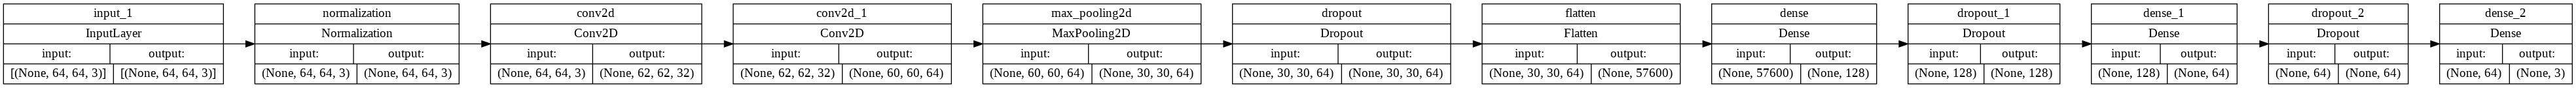

In [10]:
keras.utils.plot_model(model, rankdir='LR', show_shapes=True)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 0.001, 
                           verbose = 1, restore_best_weights = True) 

# Addestramento
model_history = model.fit(train_set, epochs = 25,
                                validation_data = valid_set,
                                verbose = 1, callbacks = [early_stop])

Epoch 1/25
122/122 [==============================] - 589s 5s/step - loss: 4.8618 - accuracy: 0.4380 - val_loss: 0.5645 - val_accuracy: 0.7639
Epoch 2/25
122/122 [==============================] - 17s 136ms/step - loss: 0.4835 - accuracy: 0.8022 - val_loss: 0.2178 - val_accuracy: 0.9236
Epoch 3/25
122/122 [==============================] - 16s 135ms/step - loss: 0.2767 - accuracy: 0.8915 - val_loss: 0.2223 - val_accuracy: 0.9190
Epoch 4/25
122/122 [==============================] - 16s 134ms/step - loss: 0.2125 - accuracy: 0.9198 - val_loss: 0.2161 - val_accuracy: 0.9213
Epoch 5/25
122/122 [==============================] - 16s 131ms/step - loss: 0.1345 - accuracy: 0.9501 - val_loss: 0.2371 - val_accuracy: 0.9421
Epoch 6/25
122/122 [==============================] - 17s 136ms/step - loss: 0.1066 - accuracy: 0.9614 - val_loss: 0.2569 - val_accuracy: 0.9282
Epoch 7/25
122/122 [==============================] - 17s 137ms/step - loss: 0.0825 - accuracy: 0.9668 - val_loss: 0.3507 - val_accu

Numero di epoche totali: 9
Epoca migliore (weights restored): 4
Accuracy training set all'epoca 4: 0.9197530746459961
Accuracy validation set all'epoca 4: 0.9212962985038757
Loss training set all'epoca 4: 0.21248552203178406
Loss validation set all'epoca 4: 0.21605053544044495





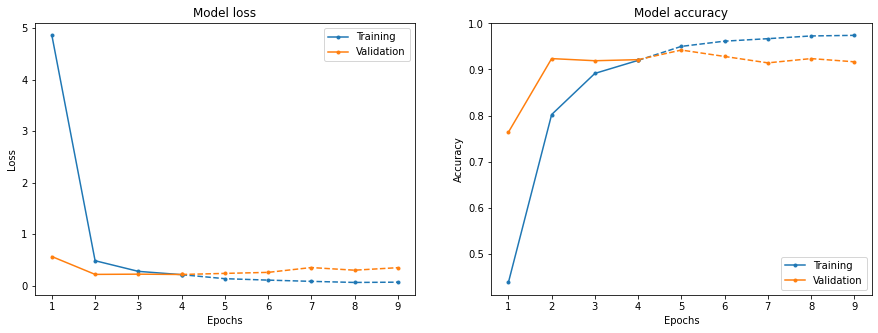

In [ ]:
resume_model_history(model_history, early_stop = early_stop)

L'addestramento consiste in sole 4 epoche grazie all'Early Stopping che permette di eseguire tutte le 25 epoche impostate inizialmente. Il modello overfitta leggermente sulla loss e un underfitta invece sull'accuracy. Nonostante questo il modello può essere considerato globalmente buono, come si può vedere dai risultati ottenuti sotto.

In [ ]:
# Classificazione sul test set
y_pred = model.predict(test_set)

In [ ]:
y_predict = []
for i in range(len(y_pred)):
  y_predict.append(np.argmax(y_pred[i]))
y_predict = np.array(y_predict)
y_test = test_set.labels


Classification Report
               precision    recall  f1-score   support

     Ginevra       0.93      0.92      0.92       160
     Lorenzo       0.87      0.85      0.86       160
    Riccardo       0.84      0.87      0.86       160

    accuracy                           0.88       480
   macro avg       0.88      0.88      0.88       480
weighted avg       0.88      0.88      0.88       480





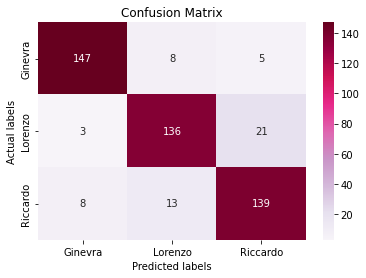

In [ ]:
# Valutazione performance
evaluate_prediction(y_test, y_predict)

Le performance complessive risultano molto elevate, l'accuratezza è infatti pari a 0.88; è minore rispetto a quella ottenuta sul validation set, ma è comunque alta. <br>
Dall'osservazione della matrice di confusione si nota come gli audio di Ginevra sono quelli che il modello riesce a riconoscere più abilmente, a differenza di quelli di Lorenzo che spesso vengono confusi con quelli di Riccardo.
Infatti testando nuove registrazioni raccolte in un secondo momento, la rete reagisce bene con audio di Ginevra, mentre fatica a riconoscere correttamente quelli di Lorenzo e Riccardo. Questo può essere dovuto al fatto che le due voci maschili possono avere dei tratti simili che il classificatore non riesce a distinguere perfettamente. Un'altra motivazione può essere legata alle condizioni di registrazione degli audio e al ritmo del parlato che potrebbe essere diverso da quello usato per registrare gli audio di partenza.


In [ ]:
# salvataggio del modello
model.save(MODEL_PATH + 'modelSpectrogram_compressed.h5')

### Valutazione modelli neurali su test wild
Come per SVM e RandomForest testiamo i due migliori modelli neurali (spectogram e from scrach senza dati aumentati) sul test set wild.

Predizione con la rete from scratch

In [ ]:
# se necessario ricarico il modello da drive
model_scrach = keras.models.load_model(MODEL_PATH + 'scratch.h5')

In [ ]:
%%time
evaluationWild(model_scrach, path_wild, type_class = 'nn')

True Label:  	 	 Segmento numero:  	 	 Label predetta: 
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------

La rete performa meglio rispetto ai modelli base, tuttavia richiede molto più tempo computazionale. La rete sembra adattarsi bene a nuovi audio fuori dal contesto della lettura <br>
Si prova ad effettuare la stessa predizione con la rete addestrata con gli spettrogrammi.

In [ ]:
model_spect = keras.models.load_model(MODEL_PATH + 'modelSpectrogram_compressed.h5')

In [ ]:
%%time
evaluationWild(model_spect, path_wild, type_class = 'spect')

True Label:  	 	 Segmento numero:  	 	 Label predetta: 
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Lorenzo
  Ginevra 	 	 	 3 	 	 	     Lorenzo
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Ginevra
  -------- 	 	        --- 	 	 	     --------
  Ginevra 	 	 	 1 	 	 	     Ginevra
  Ginevra 	 	 	 2 	 	 	     Ginevra
  Ginevra 	 	 	 3 	 	 	     Ginevra
  Ginevra 	 	 	 4 	 	 	     Lorenzo
  -------- 	 	        --- 	 	 	     --------

Dai risultati si evince che la rete basata sugli spettrogrammi faccia più fatica ad adattarsi a nuovi audio fuori contesto della lettura. Inoltre stupisce che nonostante richieda di salvare il file per creare lo spettrogramma il tempo risulti essere minore rispetto alla rete from scratch.

In [12]:
# download notebook in .html extension
%%shell
jupyter nbconvert --to html '/content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Notebook/Processing-1D/2_AudioRecognition.ipynb'

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Notebook/Processing-1D/2_AudioRecognition.ipynb to html
[NbConvertApp] Writing 2418820 bytes to /content/gdrive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Notebook/Processing-1D/2_AudioRecognition.html
